# Experimenting with various Kernel Combinations

## SE + Periodic

Here I will be experimenting with a range of different kernel combinations, to see which one is able to model sunspot number the best.

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az
import theano.tensor as tt

In [2]:
df = pd.read_csv('../../../Data/Savitzky-Golay Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values

In [3]:
# Define Sinusoidal Mean Function
class SinusoidalMean(pm.gp.mean.Mean):
    def __init__(self, amplitude):
        super().__init__()
        self.amplitude = amplitude
    
    def __call__(self, x):
        return tt.log(self.amplitude * tt.sin(x[:, 0] * np.pi / period + phase)**2 + offset)

## Data Preprocessing

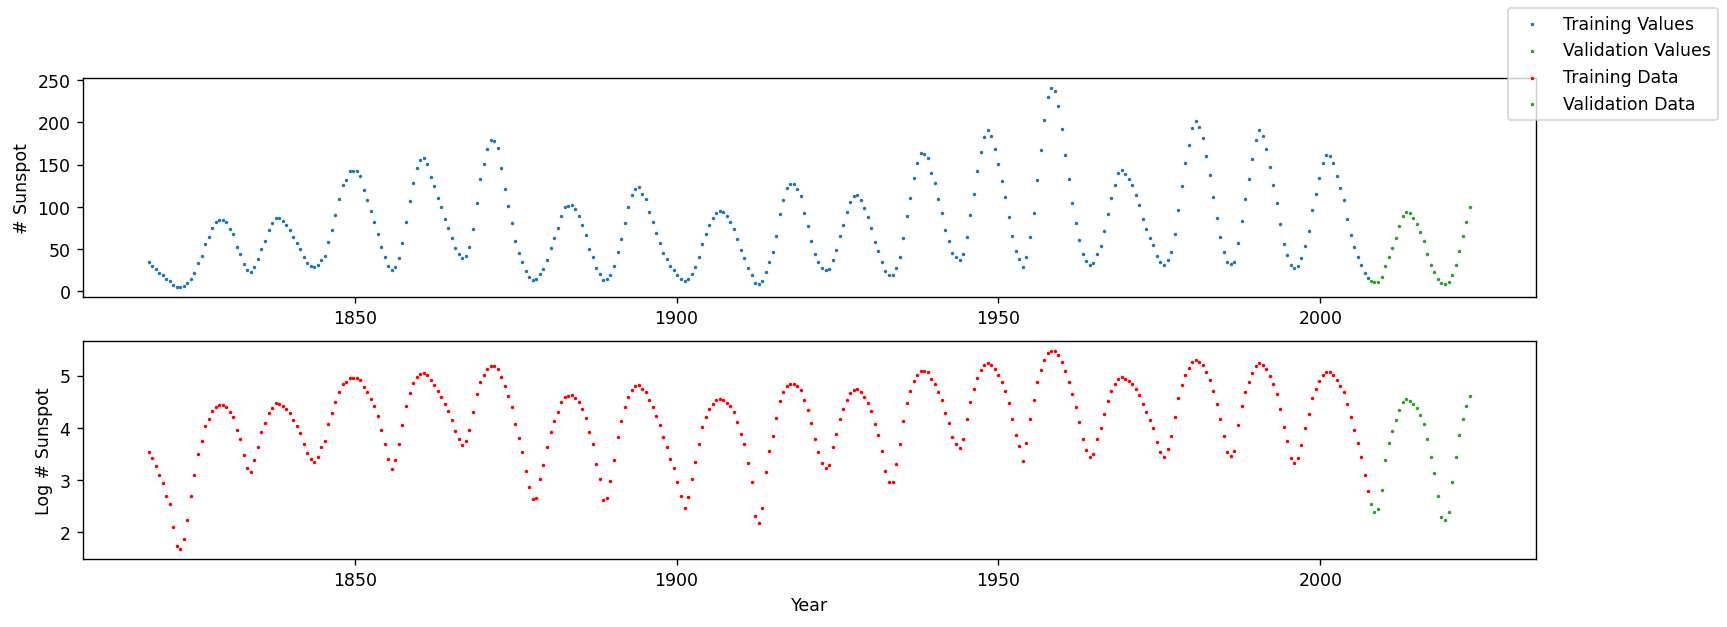

In [4]:
limit = int(0.925*len(X)) # end point of full data when training
skips = 200 # number of points skipped

train_data = df.iloc[:limit:skips] 
validation_data = df.iloc[limit::skips]

training_values = (train_data.Year.values).reshape(-1,1), train_data.Sunspot_Number.values
validation_values = (validation_data.Year.values).reshape(-1,1), validation_data.Sunspot_Number.values

training_data = training_values[0], np.log(training_values[1]) 
validation_data = validation_values[0], np.log(validation_values[1])

# take logs to obtain positive definite values
X_train = training_data[0]
y_train = training_data[1]

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])

ax[0].scatter(training_values[0], training_values[1], label='Training Values', s=1)
ax[0].scatter(validation_values[0], validation_values[1], label='Validation Values', s=1, color='tab:green')
ax[0].set_ylabel("# Sunspot")
ax[1].scatter(training_data[0], training_data[1], label='Training Data', s=1, color='red')
ax[1].scatter(validation_data[0], validation_data[1], label='Validation Data', s=1, color='tab:green')
ax[1].set_ylabel("Log # Sunspot")
ax[1].set_xlabel('Year')
fig.legend();

## GP Regression

In [5]:
# Define the Gaussian Process
with pm.Model() as model:

    # Define the phase of the sinusoidal mean
    phase = pm.Normal('phase', 1.73, 0.5) 
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Uniform('amplitude', 0, 250) 
     
    # Define the offset of the sinusoidal mean
    offset = pm.Uniform('offset', 0, 100) 
    
    # Define the `Period' 
    period = pm.Uniform('period', 9, 12)
    
    # Define the `length scale 1' of the periodic kernel
    length_scale1 = pm.Uniform('Length Scale 1', 0, 5)  
    
    # Define the `length_scale 2' of the squared-exponential kernel 
    length_scale2 = pm.Uniform('Length Scale 2', 9, 15)
    
    # Define the `Standard deviation' 
    sigma = pm.Uniform('$\sigma$', 0.0, 1)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov = cov_SE + cov_periodic 
    
    sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov, mean_func=sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a mo

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, Length Scale 2, Length Scale 1, period, offset, amplitude, phase]


/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16069 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


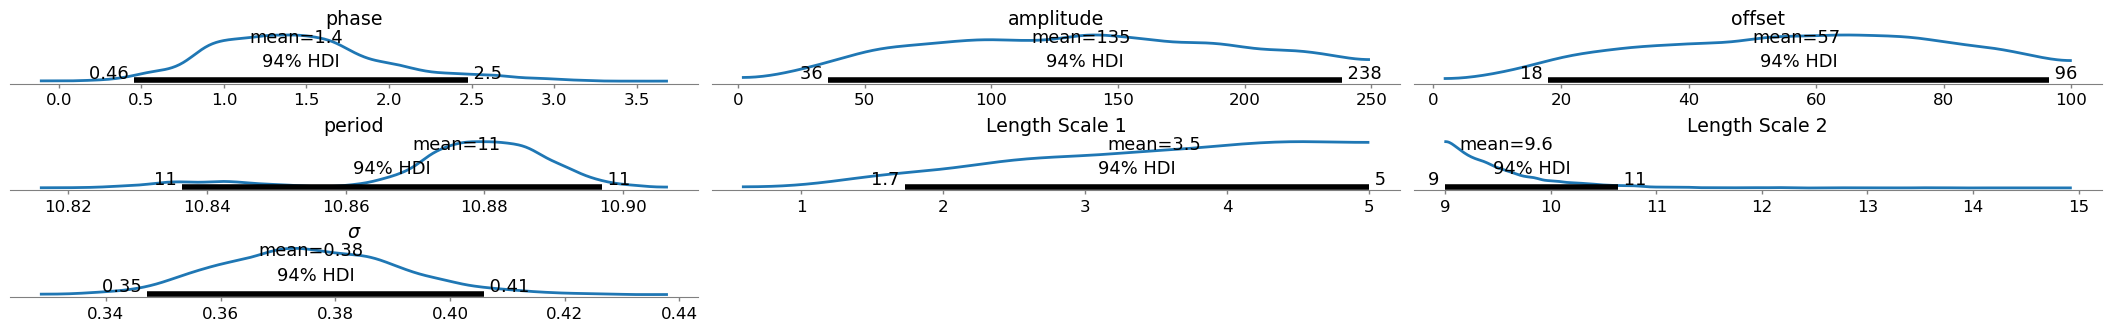

In [6]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12);
#plt.savefig('gp post.png'); 

In [7]:
X_new = validation_data[0]
with model:
    fnew = gp.conditional("f_taylor1", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_taylor1"])#

/Applications/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


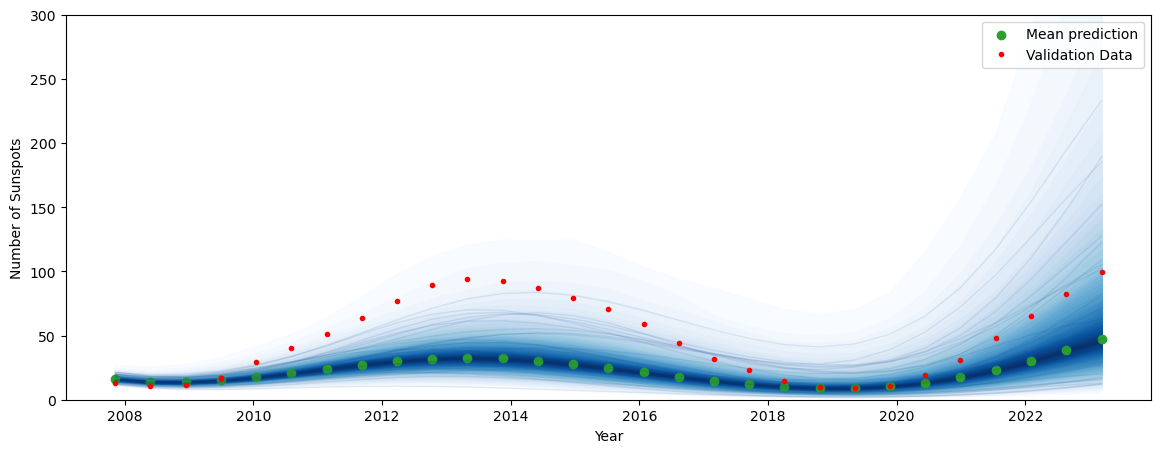

In [8]:
from pymc3.gp.util import plot_gp_dist

# Sampling predictions
mu = np.exp(np.mean(ppc['f_taylor1'], axis=0))
std = np.exp(np.std(ppc['f_taylor1'], axis=0))

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_taylor1']), X_new, palette="Blues")
# np.exp() to return log value to normal value

plt.scatter(X_new, mu, color = 'tab:green', label='Mean prediction')
# plot original data and GP
plt.plot(validation_data[0], np.exp(validation_data[1]), "or", ms=3, alpha=1.0, label="Validation Data")
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
#plt.xlim(1800,2050)
plt.ylim(0,300)
plt.legend();
#plt.savefig('GD prediction');

In [9]:
import csv

# Calculating MSE and MAE
mse = np.mean((mu - np.exp(validation_data[1]))**2)
mae = np.mean(np.abs(mu - np.exp(validation_data[1])))

print("MSE: ", mse)
print("MAE: ", mae)

# Saving MSE and MAE to CSV
with open('Metrics/Split 1/SE_plus_Per_errors.csv', mode='w') as csv_file:
    fieldnames = ['Metric', 'Value']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerow({'Metric': 'MSE', 'Value': mse})
    writer.writerow({'Metric': 'MAE', 'Value': mae})

MSE:  1133.2992917937395
MAE:  26.26157611386464


In [10]:
X_new = np.linspace(1818, 2023, 1000)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"]);

/Applications/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [11]:
# create a dataframe from the posterior predictive samples
df = pd.DataFrame(np.exp(ppc["f_new"]), index=X_new.flatten())

# save the dataframe to a CSV file
df.to_csv("GP Model Data/Split 1/SE_plus_Per.csv")